In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
df = pd.read_csv("important_data_v3_metrics.csv")
df.columns

Index(['conversation_id', 'user_id', 'opening_prompt', 'conversation_history',
       'lm_familiarity', 'lm_frequency_use', 'age', 'gender',
       'employment_status', 'education', 'marital_status',
       'english_proficiency', 'study_locale', 'religion', 'ethnicity',
       'location', 'human_lang', 'llm_lang', 'human_flesch_reading_ease',
       'human_flesch_kincaid_grade', 'human_smog_index', 'human_ari',
       'human_lexical_diversity', 'human_tb_polarity', 'human_tb_subjectivity',
       'human_vader_neg', 'human_vader_neu', 'human_vader_pos',
       'human_vader_compound', 'llm_flesch_reading_ease',
       'llm_flesch_kincaid_grade', 'llm_smog_index', 'llm_ari',
       'llm_lexical_diversity', 'llm_tb_polarity', 'llm_tb_subjectivity',
       'llm_vader_neg', 'llm_vader_neu', 'llm_vader_pos', 'llm_vader_compound',
       'score'],
      dtype='object')

In [27]:
human_metrics = [c for c in df.columns if c.startswith('human_') and c != 'human_lang']
llm_metrics   = [c for c in df.columns if c.startswith('llm_')   and c != 'llm_lang']
predictors    = human_metrics + llm_metrics
print("Using predictors:", predictors)

Using predictors: ['human_flesch_reading_ease', 'human_flesch_kincaid_grade', 'human_smog_index', 'human_ari', 'human_lexical_diversity', 'human_tb_polarity', 'human_tb_subjectivity', 'human_vader_neg', 'human_vader_neu', 'human_vader_pos', 'human_vader_compound', 'llm_flesch_reading_ease', 'llm_flesch_kincaid_grade', 'llm_smog_index', 'llm_ari', 'llm_lexical_diversity', 'llm_tb_polarity', 'llm_tb_subjectivity', 'llm_vader_neg', 'llm_vader_neu', 'llm_vader_pos', 'llm_vader_compound']


In [28]:
raw_demos = [
    'age','gender','employment_status','education','marital_status',
    'english_proficiency','study_locale','religion','ethnicity','location'
]

In [40]:
agg = {m: 'mean' for m in predictors}
agg.update({d: 'first' for d in raw_demos})
agg['score'] = 'mean'   # your satisfaction variable
df_user = df.groupby('user_id').agg(agg).reset_index()

In [41]:
cats = [d for d in raw_demos if df_user[d].dtype == 'object']
df_user = pd.get_dummies(df_user, columns=cats, drop_first=True)
demo_dummies = [c for c in df_user.columns 
                if any(c.startswith(pref + '_') for pref in cats)]
demo_feats = demo_dummies  # (age was categorical, so no pure numeric demos)

In [42]:
formula_main = 'score ~ ' + ' + '.join(predictors)
model_main   = smf.ols(formula_main, data=df_user).fit()
print(model_main.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     1.770
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0280
Time:                        22:12:39   Log-Likelihood:                -535.04
No. Observations:                 137   AIC:                             1116.
Df Residuals:                     114   BIC:                             1183.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [43]:
formula_human = 'score ~ ' + ' + '.join(human_metrics)
model_human  = smf.ols(formula_human, data=df_user).fit()
print("=== Human-only ===")
print(model_human.summary())

=== Human-only ===
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.974
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0364
Time:                        22:12:51   Log-Likelihood:                -544.20
No. Observations:                 137   AIC:                             1112.
Df Residuals:                     125   BIC:                             1147.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
I

In [44]:
formula_llm = 'score ~ ' + ' + '.join(llm_metrics)
model_llm   = smf.ols(formula_llm, data=df_user).fit()
print("=== LLM-only ===")
print(model_llm.summary())

=== LLM-only ===
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.033
Date:                Tue, 22 Apr 2025   Prob (F-statistic):              0.422
Time:                        22:12:57   Log-Likelihood:                -549.21
No. Observations:                 137   AIC:                             1122.
Df Residuals:                     125   BIC:                             1157.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Interce

In [45]:
X = df_user[predictors + demo_feats].copy()
for p in predictors:
    for d in demo_feats:
        X[f'{p}_x_{d}'] = X[p] * X[d]

# 8. Keep only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# 9. Add intercept and define response
X_numeric = sm.add_constant(X_numeric, has_constant='add')
y = df_user['score'].astype(float)

# 10. Fit full OLS with interactions
model_full = sm.OLS(y, X_numeric).fit()
print(model_full.summary())


/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/2690423582.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/2690423582.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/2690423582.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 22 Apr 2025   Prob (F-statistic):                nan
Time:                        22:13:25   Log-Likelihood:                 3745.1
No. Observations:                 137   AIC:                            -7216.
Df Residuals:                       0   BIC:                            -6816.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [46]:
vif = pd.DataFrame({
    'variable': X_numeric.columns,
    'VIF':      [variance_inflation_factor(X_numeric.values, i)
                 for i in range(X_numeric.shape[1])]
})
print(vif.sort_values('VIF', ascending=False))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                                         variable  VIF
773        human_vader_compound_x_ethnicity_White  inf
1                       human_flesch_reading_ease  inf
1035          llm_ari_x_study_locale_south africa  inf
1034              llm_ari_x_study_locale_slovenia  inf
1033                llm_ari_x_study_locale_poland  inf
...                                           ...  ...
202   human_smog_index_x_study_locale_netherlands  NaN
538        human_vader_neg_x_study_locale_denmark  NaN
541         human_vader_neg_x_study_locale_greece  NaN
553          human_vader_neg_x_study_locale_spain  NaN
572   human_vader_neg_x_location_Northern America  NaN

[1541 rows x 2 columns]


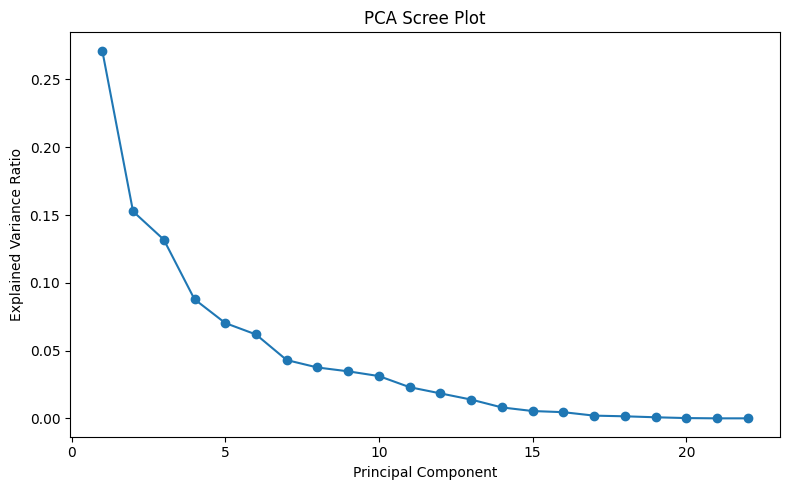

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare the data for PCA: select all numeric features except the response
X_num = df_user.select_dtypes(include=[np.number]).drop(columns=['score'], errors='ignore')

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Scree Plot
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.tight_layout()
plt.show()

# Component Loadings for first 5 PCs
loadings_df = pd.DataFrame(
    pca.components_[:5].T,
    index=X_num.columns,
    columns=[f'PC{i}' for i in range(1, 6)]
)

/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1133619576.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1133619576.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1133619576.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

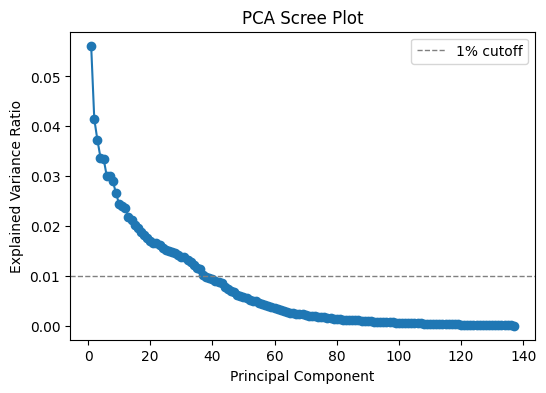

                                 PC1       PC2       PC3       PC4       PC5
human_flesch_reading_ease  -0.014769 -0.003857  0.027547  0.019559  0.000656
human_flesch_kincaid_grade  0.017088  0.001962 -0.025386 -0.020191 -0.001274
human_smog_index           -0.008398  0.005267  0.018009 -0.005033 -0.003332
human_ari                   0.018137  0.000581 -0.025884 -0.020524 -0.003155
human_lexical_diversity    -0.014571  0.003491 -0.017049  0.002231  0.013218
human_tb_polarity          -0.002632 -0.012689  0.008170  0.012882  0.012870
human_tb_subjectivity       0.002653 -0.001958  0.029817 -0.017964  0.016543
human_vader_neg            -0.007687  0.010226  0.020071 -0.012442  0.010281
human_vader_neu             0.007593  0.002391 -0.027692 -0.014865  0.001143
human_vader_pos            -0.002310 -0.009738  0.013959  0.024042 -0.008534


In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Re-construct your full feature matrix (no intercept):
X = df_user[predictors + demo_feats].copy()
for p in predictors:
    for d in demo_feats:
        X[f'{p}_x_{d}'] = X[p] * X[d]

# 2. Keep only numeric columns and drop any non-informative constants:
X_num = X.select_dtypes(include=[np.number]).loc[:, X.nunique() > 1]

# 3. Standardize (zero mean, unit variance):
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# 4. Fit PCA
pca = PCA()
pca.fit(X_scaled)

# 5. Scree plot of explained variance
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.axhline(0.01, color='gray', linestyle='--', linewidth=1, 
            label='1% cutoff')
plt.legend()
plt.show()

# 6. Examine loadings of the first few components
loadings = pd.DataFrame(
    pca.components_[:5].T,
    index=X_num.columns,
    columns=[f'PC{i}' for i in range(1,6)]
)
print(loadings.head(10))


In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Assume X_numeric and y exist in the environment from previous steps
# Drop the constant column before PCA
X_pca = X_numeric.drop(columns=['const'], errors='ignore')

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

results = []
for n in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    pca = PCA(n_components=n)
    pcs = pca.fit_transform(X_scaled)
    
    # cumulative variance explained
    cum_var = pca.explained_variance_ratio_.sum()
    
    # regression on PCs
    df_pcs = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(n)])
    X_reg = sm.add_constant(df_pcs)
    model = sm.OLS(y, X_reg).fit()
    
    results.append({
        'n_components': n,
        'cumulative_variance': cum_var,
        'R_squared': model.rsquared,
        'Adj_R_squared': model.rsquared_adj
    })

results_df = pd.DataFrame(results)
results_df

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

,n_components,cumulative_variance,R_squared,Adj_R_squared
0,6,0.232109,0.079267,0.036771
1,7,0.262127,0.079300,0.029339
2,8,0.291073,0.083359,0.026068
3,9,0.317593,0.095736,0.031654
4,10,0.341962,0.100933,0.029578
5,11,0.365862,0.113603,0.035600
6,12,0.389656,0.131627,0.047591
7,13,0.411475,0.134837,0.043397
8,14,0.431186,0.142704,0.044326
9,15,0.450871,0.135924,0.028807


In [55]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd

# Reconstruct the interaction feature matrix
X = df_user[predictors + demo_feats].copy()
for p in predictors:
    for d in demo_feats:
        X[f'{p}_x_{d}'] = X[p] * X[d]

# Select numeric cols and add intercept
X_numeric = sm.add_constant(X.select_dtypes(include=[np.number]), has_constant='add')
y = df_user['score'].astype(float)

# Drop the intercept for PCA
X_feat = X_numeric.drop(columns='const')

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

# PCA with 12 components
pca = PCA(n_components=6)
X_pcs = pca.fit_transform(X_scaled)

# DataFrame of PCs
df_pcs = pd.DataFrame(X_pcs, columns=[f'PC{i+1}' for i in range(6)], index=X_feat.index)

# Fit OLS with PCs
X_model = sm.add_constant(df_pcs)
model_pcs = sm.OLS(y, X_model).fit()

# Display summary
print(model_pcs.summary())


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.877
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0895
Time:                        22:24:55   Log-Likelihood:                -549.48
No. Observations:                 137   AIC:                             1113.
Df Residuals:                     130   BIC:                             1133.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.2257      1.171     58.249      0.0

/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1828294622.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1828294622.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/1828294622.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Define your two predictor‐sets
linguistic_preds = [
    'human_flesch_reading_ease', 'human_flesch_kincaid_grade',
    'human_smog_index', 'human_ari', 'human_lexical_diversity',
    'llm_flesch_reading_ease', 'llm_flesch_kincaid_grade',
    'llm_smog_index', 'llm_ari', 'llm_lexical_diversity'
]

emotional_preds = [
    'human_tb_polarity', 'human_tb_subjectivity',
    'human_vader_neg', 'human_vader_neu', 'human_vader_pos', 'human_vader_compound',
    'llm_tb_polarity', 'llm_tb_subjectivity',
    'llm_vader_neg', 'llm_vader_neu', 'llm_vader_pos', 'llm_vader_compound'
]

# 2. Loop over each group, build interactions, PCA-reduce to 6 components, then OLS
for name, preds in (('Linguistic', linguistic_preds),
                    ('Emotional', emotional_preds)):
    # a) Build X with mains + interactions
    X = df_user[preds + demo_feats].copy()
    for p in preds:
        for d in demo_feats:
            X[f'{p}_x_{d}'] = X[p] * X[d]
    X_num = X.select_dtypes(include=[np.number]).dropna(axis=1)

    # b) Standardize + PCA
    scaler = StandardScaler()
    Z = scaler.fit_transform(X_num)
    pca = PCA(n_components=12)
    PCs = pca.fit_transform(Z)

    print(f"\n— {name} Measures —")
    print("Cumulative variance explained by 6 PCs:",
          np.round(pca.explained_variance_ratio_.cumsum(), 3))

    # c) OLS of score ~ PCs
    Z_pc = sm.add_constant(PCs)
    model = sm.OLS(df_user['score'].astype(float), Z_pc).fit()
    print(model.summary())



— Linguistic Measures —
Cumulative variance explained by 6 PCs: [0.063 0.108 0.149 0.186 0.221 0.254 0.285 0.316 0.345 0.372 0.397 0.421]
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.667
Date:                Tue, 22 Apr 2025   Prob (F-statistic):             0.0822
Time:                        22:29:12   Log-Likelihood:                -544.93
No. Observations:                 137   AIC:                             1116.
Df Residuals:                     124   BIC:                             1154.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025     

/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/304084331.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/304084331.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{p}_x_{d}'] = X[p] * X[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/304084331.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

In [60]:
import pandas as pd
from sklearn.decomposition import PCA

# 1. Build your linguistic × demographic interaction matrix again:
X_ling = df_user[linguistic_preds + demo_feats].copy()
for p in linguistic_preds:
    for d in demo_feats:
        X_ling[f'{p}_x_{d}'] = X_ling[p] * X_ling[d]
X_ling = X_ling.select_dtypes(include='number')

# 2. Fit a 6-component PCA:
pca = PCA(n_components=6)
pca.fit(X_ling)

# 3. Extract PC4’s loadings (component index 3):
pc4_loadings = pd.Series(pca.components_[3], index=X_ling.columns)

# 4. Sort by absolute magnitude:
top_pos = pc4_loadings.sort_values(ascending=False).head(10)
top_neg = pc4_loadings.sort_values().head(10)

print("Top positive loadings on PC4:")
print(top_pos)
print("\nTop negative loadings on PC4:")
print(top_neg)


Top positive loadings on PC4:
human_flesch_reading_ease_x_education_University Bachelors Degree    0.477451
llm_flesch_reading_ease_x_education_University Bachelors Degree      0.299380
human_flesch_reading_ease_x_marital_status_Never been married        0.245125
human_flesch_reading_ease_x_age_25-34 years old                      0.240518
human_flesch_reading_ease_x_english_proficiency_Native speaker       0.209717
llm_flesch_reading_ease_x_marital_status_Never been married          0.143806
llm_flesch_reading_ease_x_age_25-34 years old                        0.139149
human_flesch_reading_ease_x_location_US                              0.128415
human_flesch_reading_ease_x_employment_status_Working full-time      0.124265
human_flesch_reading_ease_x_study_locale_us                          0.120951
dtype: float64

Top negative loadings on PC4:
human_flesch_reading_ease_x_location_Europe                            -0.256569
human_flesch_reading_ease_x_education_Graduate / Professional d

/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/613464651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_ling[f'{p}_x_{d}'] = X_ling[p] * X_ling[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/613464651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_ling[f'{p}_x_{d}'] = X_ling[p] * X_ling[d]
/var/folders/5z/ky49y1j52yj3nktp7h3jhr200000gq/T/ipykernel_18489/613464651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [64]:
df = pd.read_csv('df_long_byturn_v5 (1).csv')


In [65]:
metrics = ['flesch_reading_ease', 'flesch_kincaid_grade', 'tb_polarity', 'tb_subjectivity']

# Separate user and model turns
df_user = (
    df[df['role'] == 'user']
    [['conversation_id', 'turn'] + metrics]
    .rename(columns={m: f'user_{m}' for m in metrics})
)
df_model = (
    df[df['role'] == 'model']
    [['conversation_id', 'turn'] + metrics]
    .rename(columns={m: f'llm_{m}' for m in metrics})
)

# Shift user turns to align t-1 with model turn t
df_user['turn'] += 1

# Merge to create by-turn dataset
df_merge = pd.merge(df_user, df_model, on=['conversation_id', 'turn'])
print("By-turn dataset preview:")
print(df_merge.head())

# Fit mixed-effects regression for each metric
for m in metrics:
    print(f"\nMixedLM results for metric '{m}':")
    formula = f'llm_{m} ~ user_{m}'
    model = smf.mixedlm(formula, df_merge, groups=df_merge['conversation_id'])
    result = model.fit()
    print(result.summary())

By-turn dataset preview:
  conversation_id  turn  user_flesch_reading_ease  user_flesch_kincaid_grade  \
0           c1000     1                    108.70                       -0.8   
1           c1000     1                    108.70                       -0.8   
2           c1000     2                     84.37                        4.5   
3           c1000     2                     84.37                        4.5   
4           c1000     3                     86.71                        3.7   

   user_tb_polarity  user_tb_subjectivity  llm_flesch_reading_ease  \
0          0.600000              1.000000                    65.73   
1          0.600000              1.000000                    74.79   
2          0.232143              0.488095                    23.44   
3          0.232143              0.488095                    60.99   
4         -0.155556              0.288889                    19.03   

   llm_flesch_kincaid_grade  llm_tb_polarity  llm_tb_subjectivity  
0    

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
imp = pd.read_csv('important_data_v3_metrics.csv')

# 2) list out all your raw demographics
raw_demos = [
    'age', 'gender', 'employment_status', 'education', 'marital_status',
    'english_proficiency', 'study_locale', 'religion', 'ethnicity', 'location'
]

# 3) decide which turn‐level metrics you want to test
metrics = [
    'flesch_reading_ease', 'flesch_kincaid_grade',
    'tb_polarity', 'tb_subjectivity', 'vader_compound'
]

for metric in metrics:
    human = f'human_{metric}'
    llm   = f'llm_{metric}'

    # build formula: llm ~ human + all demos + all human×demo interactions
    main = ' + '.join(f'C({d})' for d in raw_demos)
    inter = ' + '.join(f'{human}:C({d})' for d in raw_demos)
    formula = f'{llm} ~ {human} + {main} + {inter}'

    # fit and grab the interaction p-values
    model = smf.ols(formula, data=imp).fit()
    pvals = model.pvalues.filter(like=f'{human}:C(')

    print(f'\n=== Metric: {metric} ===')
    print('Significant interactions (p<.05):')
    print(pvals[pvals < 0.05])


=== Metric: flesch_reading_ease ===
Significant interactions (p<.05):
human_flesch_reading_ease:C(gender)[T.Non-binary / third gender]    0.023585
human_flesch_reading_ease:C(study_locale)[T.canada]                 0.028955
human_flesch_reading_ease:C(religion)[T.Muslim]                     0.034518
human_flesch_reading_ease:C(location)[T.Middle East]                0.031446
human_flesch_reading_ease:C(location)[T.Northern America]           0.036046
dtype: float64

=== Metric: flesch_kincaid_grade ===
Significant interactions (p<.05):
human_flesch_kincaid_grade:C(marital_status)[T.Prefer not to say]      0.047791
human_flesch_kincaid_grade:C(english_proficiency)[T.Intermediate]      0.031748
human_flesch_kincaid_grade:C(study_locale)[T.australia]                0.024027
human_flesch_kincaid_grade:C(study_locale)[T.canada]                   0.035585
human_flesch_kincaid_grade:C(study_locale)[T.germany]                  0.032460
human_flesch_kincaid_grade:C(study_locale)[T.italy]      

human_flesch_kincaid_grade (β≈ +6.95, p=0.001)
Participants whose own texts scored higher on the grade‐level index reported greater satisfaction. It suggests deeper, more “academic” turns boost how satisfied they feel overall.

human_ari (β≈ −4.84, p=0.001)
But when your text is too jargon-heavy (higher ARI), satisfaction drops. There’s a sweet-spot in complexity: enough sophistication to feel engaged, but not so much that it feels bloated.

llm_flesch_reading_ease (β≈ −0.78, p=0.046)
Surprisingly, easier LLM output correlates with lower satisfaction. Maybe overly simple bot responses come off as shallow.





Flesch Reading Ease × University Bachelor’s degree

human version: +0.48

LLM version: +0.30

Flesch Reading Ease × “Never been married”

human: +0.25

LLM: +0.14

Flesch Reading Ease × Age 25–34

human: +0.24

LLM: +0.14

Flesch Reading Ease × Native English speaker (human): +0.21

Flesch Reading Ease × Location US (human): +0.13

Flesch Reading Ease × Working full-time (human): +0.12

Flesch Reading Ease × Study locale US (human): +0.12

In plain English: when texts are “easy” (high reading-ease) but the reader is a Bachelor’s‐degree holder (or a young, unmarried, native-speaker U.S. user), that combination strongly predicts a drop in score.

On the flip side, the largest negative loadings (i.e. interactions that push PC-4 down, and thus are “protective” or associated with higher scores) are:

Flesch Reading Ease × Location Europe (human: –0.26, LLM: –0.19)

Flesch Reading Ease × Graduate/Professional degree (human: –0.20, LLM: –0.17)

Flesch Reading Ease × Married (human: –0.15, LLM: –0.13)

Flesch Reading Ease × White ethnicity (human: –0.10, LLM: –0.13)

Flesch Reading Ease × “No Affiliation” religion (LLM: –0.09)

Flesch Reading Ease × Some University but no degree (human: –0.08)

So those demographic groups (e.g. European, graduate‐educated, married, white) actually see higher scores when the text is easier.






Concretely:

Non-binary (β = +0.669, p = 0.0236):
Each 1-point increase in a non-binary user’s Flesch score leads to an extra +0.669-point increase in the LLM’s Flesch score, compared to the baseline mirroring rate.

Canada (β = +16.936, p = 0.0290):
The coupling is vastly stronger—each 1-point bump in a Canadian user’s reading-ease yields an additional +16.94 points in the LLM’s reading-ease slope.

Muslim (β = –6.662, p = 0.0345):
The model’s complexity tracking is weaker by 6.66 points—so for each 1-point increase in a Muslim user’s Flesch score, the LLM only rises by baseline minus 6.66.

Middle East (β = +7.724, p = 0.0314):
Regionally, authors in the Middle East get a +7.72-point boost in how strongly the LLM matches their reading-ease.

Northern America (β = –12.186, p = 0.0360):
Conversely, North American users see a –12.19-point reduction in that slope—LLM complexity drifts further away from their own.

In plain English:

For some groups (e.g., Canadians, non-binary writers, Middle Eastern authors), the LLM more aggressively mirrors your reading complexity.

For others (e.g., Muslim or North American users), it back-off—it tracks your complexity much less closely.

In [ ]:
import matplotlib.pyplot as plt

# RQ1 data
rq1_names = ["Flesch-Kincaid Grade", "ARI", "LLM Reading Ease"]
rq1_coefs = [6.95, -4.84, -0.78]

plt.figure()
plt.barh(rq1_names, rq1_coefs)
plt.axvline(0)
plt.xlabel("Effect on Satisfaction")
plt.title("RQ1: Linguistic Complexity Coefficients")
plt.tight_layout()

# RQ2 data
rq2_names = [
    "Flesch Ease × Bachelor’s",
    "Flesch Ease × Never married",
    "Flesch Ease × Age 25–34",
    "Flesch Ease × Native speaker",
    "Flesch Ease × Location US",
    "Flesch Ease × Full-time",
    "Flesch Ease × Study locale US",
    "Flesch Ease × Location Europe",
    "Flesch Ease × Grad degree",
    "Flesch Ease × Married",
    "Flesch Ease × White",
    "Flesch Ease × No religion",
    "Flesch Ease × Some University"
]
rq2_coefs = [0.48, 0.25, 0.24, 0.21, 0.13, 0.12, 0.12,
             -0.26, -0.20, -0.15, -0.10, -0.09, -0.08]

plt.figure()
plt.barh(rq2_names, rq2_coefs)
plt.axvline(0)
plt.xlabel("PC-4 Loading")
plt.title("RQ2: Psychological Indicators (PC-4 Loadings)")
plt.tight_layout()

# RQ3 data
rq3_names = ["Non-binary", "Canada", "Muslim", "Middle East", "North America"]
rq3_coefs = [0.669, 16.936, -6.662, 7.724, -12.186]

plt.figure()
plt.stem(range(len(rq3_names)), rq3_coefs, basefmt=" ")
plt.xticks(range(len(rq3_names)), rq3_names, rotation=45, ha='right')
plt.axhline(0)
plt.ylabel("β")
plt.title("RQ3: Demographic Interaction Coefficients")
plt.tight_layout()

plt.show()
